# Connectivity betweeen ROIs

In [28]:
import os
import numpy as np
import pandas as pd
import nilearn
from nilearn import plotting
import glob
import os
from nilearn.input_data import NiftiMasker
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pymc3 as pm

In [29]:
# put functional file, confound file and event file here - this is for one subject
func_file = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-Memory_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz'
confound_file = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/derivatives/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-Memory_desc-confounds_regressors.tsv'
events_file = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_BIDS/condition_files/withNumbers/sub-{sub}_ses-{ses}_30sec_window.csv'

In [30]:
medication_cond = pd.read_csv('/home/or/kpe_task_analysis/task_based_analysis/kpe_sub_condition.csv')
medication_cond

,scr_id,med_cond
0,KPE008,1.0
1,KPE1223,1.0
2,KPE1253,0.0
3,KPE1263,0.0
4,KPE1293,1.0
5,KPE1307,1.0
6,KPE1315,1.0
7,KPE1322,1.0
8,KPE1339,1.0
9,KPE1343,1.0


In [31]:
subject_list = np.array(medication_cond.scr_id)
subject_list

array(['KPE008', 'KPE1223', 'KPE1253', 'KPE1263', 'KPE1293', 'KPE1307',
       'KPE1315', 'KPE1322', 'KPE1339', 'KPE1343', 'KPE1351', 'KPE1356',
       'KPE1364', 'KPE1369', 'KPE1387', 'KPE1390', 'KPE1403', 'KPE1464',
       'KPE1468', 'KPE1480', 'KPE1499'], dtype=object)

In [32]:
def removeVars (confoundFile):
    # this method takes the csv regressors file (from fmriPrep) and chooses a few to confound. You can change those few
    import pandas as pd
    confound = pd.read_csv(confoundFile,sep="\t", na_values="n/a")
    finalConf = confound[['csf','white_matter', 'framewise_displacement', 'dvars', 'std_dvars',
                          'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
                        ]] # can add 'global_signal' also , 
    #'a_comp_cor_00', 'a_comp_cor_01',	'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05'
     # change NaN of FD to zero
    finalConf = np.array(finalConf.fillna(0.0))
    #finalConf[0,2] = 0 # if removing FD than should remove this one also
    return finalConf

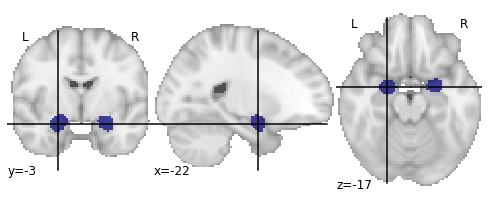

In [33]:
mask_file = '/media/Data/work/KPE_ROI/amygdala_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=25", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)

masker_amg = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                                smoothing_fwhm=4, standardize=True, detrend=True, verbose=5, t_r=1,
                                           high_pass=.01)

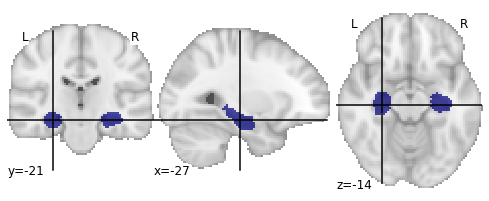

In [34]:
# hippocampus mask
mask_file_hippo = '/media/Data/work/KPE_ROI/hippocampus_association-test_z_FDR_0.01.nii.gz'
mask_file_hippo = nilearn.image.math_img("a>=13", a=mask_file_hippo)
nilearn.plotting.plot_roi(mask_file_hippo)

masker_hippo = nilearn.input_data.NiftiMasker(mask_img=mask_file_hippo, 
                                smoothing_fwhm=4, standardize=True, detrend=True, verbose=5, t_r=1,
                                           high_pass=.01)

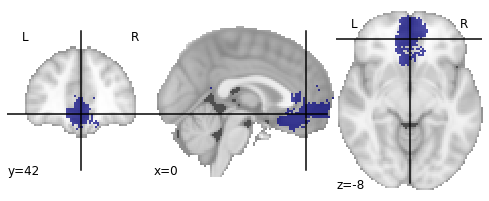

In [35]:
#vmPFC
mask_file_vmpfc = '/media/Data/work/RCF_or/vmpfc_association-test_z_FDR_0.01.nii.gz'
mask_file_vmpfc = nilearn.image.math_img("a>=5", a=mask_file_vmpfc)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file_vmpfc)

masker_vmpfc = nilearn.input_data.NiftiMasker(mask_img=mask_file_vmpfc, 
                                smoothing_fwhm=4, standardize=True, detrend=True, verbose=5, t_r=1,
                                           high_pass=.01)

In [36]:
# now start running subjects and generate average hippocampus and amugdala activity - and correlate between them
#subject_list = ['KPE008']
ses = '2'
output_dir = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/connAnalysis_ses%s' %(ses)
try:
    os.makedirs(output_dir)
except:
    print('Dir is already there')
scr_id = []
corr_amgHipp = []
corr_amgvmpfc = []
corr_hippVmpfc = []

for sub in subject_list:
    try:
        file = np.load(output_dir + '/sub-' + sub + '.npy', allow_pickle=True)
    except:
        try:
            print(f' Analysing subject {sub}')
            subject = sub.split('KPE')[1]
            scr_id.append(sub)
            func = func_file.format(sub=subject, ses=ses)
            confound = confound_file.format(sub=subject, ses=ses)
            event = events_file.format(sub=subject, ses=ses)
            # get timeline for each region
            amg = masker_amg.fit_transform(func, confounds=removeVars(confound))
            hippo = masker_hippo.fit_transform(func, confounds=removeVars(confound))
            vmpfc = masker_vmpfc.fit_transform(func, confounds=removeVars(confound))

            print(amg.shape)
            print(hippo.shape)
            # save timeseries for each subject
            x = {'amg': amg, 'hippo': hippo, 'vmpfc': vmpfc}
            np.save(output_dir + '/sub-' + sub, x)
        except:
            print(f'Subject {sub} has not data')

Dir is already there


In [465]:
ses = '1'
output_dir = '/media/Data/Lab_Projects/KPE_PTSD_Project/neuroimaging/KPE_results/connAnalysis_ses%s' %(ses)
sub = subject_list[0]
duration = 120 #set duration of event in seconds
scr_id = []
corr_amgHipp = []
corr_amgvmpfc = []
corr_hippVmpfc = []
for sub in subject_list:
    subject = sub.split('KPE')[1]
    scr_id.append(sub)
    # load the npy file
    file = np.load(output_dir + '/sub-' + sub + '.npy', allow_pickle=True)
    # load each matrix
    amg = h.item()['amg']
    hippo = h.item()['hippo']
    vmpfc = h.item()['vmpfc']
    # average for all voxels
    amg = np.mean(amg, axis=1)
    hippo = np.mean(hippo, axis =1)
    vmpfc = np.mean(vmpfc, axis=1)
    event = events_file.format(sub=subject, ses=ses)
    events = pd.read_csv(event, sep='\t')
    onset = int(events.onset[events.trial_type_30=='trauma1_0'])
    # correlate
    corr_amgHipp.append(scipy.stats.pearsonr(amg[onset:onset+duration], hippo[onset:onset+duration])[0])
    corr_amgvmpfc.append(scipy.stats.pearsonr(amg[onset:onset+duration], vmpfc[onset:onset+duration])[0])
    corr_hippVmpfc.append(scipy.stats.pearsonr(hippo[onset:onset+duration], vmpfc[onset:onset+duration])[0])

In [466]:
# fisher z transformation
corr_amgvmpfc = np.arctan(corr_amgvmpfc)
corr_amgHipp = np.arctan(corr_amgHipp)
corr_hippVmpfc = np.arctan(corr_hippVmpfc)

In [27]:
# for ses 2
df = []
df = pd.DataFrame({'scr_id': scr_id, 'corr_amgHipp2': corr_amgHipp, 'corr_amgVmpfc2': corr_amgvmpfc,
                   'corr_hippVmpfc2': corr_hippVmpfc})
df = pd.merge(medication_cond, df)
df = df.rename(columns={'med_cond': 'group'})
#df['group'] = medication_cond['med_cond']
df = df.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

ValueError: arrays must all be same length

In [467]:
# for session 1
df1 = []
df1 = pd.DataFrame({'scr_id': scr_id, 'corr_amgHipp1': corr_amgHipp, 'corr_amgVmpfc1': corr_amgvmpfc,
                   'corr_hippVmpfc1': corr_hippVmpfc})
df1 = pd.merge(medication_cond, df1)
df1 = df1.rename(columns={'med_cond': 'group'})
#df['group'] = medication_cond['med_cond']
df1 = df1.replace(to_replace={'group': {0.0:'midazolam', 1.0:'ketamine'}})

In [26]:
dfBoth = pd.merge(df,df1)
dfBoth['hippAmgDelta'] = dfBoth.corr_amgHipp2 - dfBoth.corr_amgHipp1 
dfBoth['amgVmpfcDelta'] = dfBoth.corr_amgVmpfc2 - dfBoth.corr_amgVmpfc1
dfBoth['hippVmpfcDelta'] = dfBoth.corr_hippVmpfc2 - dfBoth.corr_hippVmpfc1
dfBoth

NameError: name 'df' is not defined

Ttest_indResult(statistic=-0.6368133926734911, pvalue=0.5318447722366961)

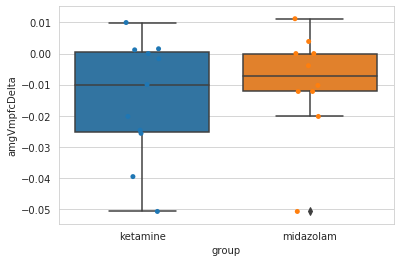

In [471]:
sns.boxplot(x ='group', y='amgVmpfcDelta', data= dfBoth)
sns.stripplot(x ='group', y='amgVmpfcDelta', data= dfBoth)
scipy.stats.ttest_ind(dfBoth['amgVmpfcDelta'][dfBoth.group=='ketamine'], 
                      dfBoth['amgVmpfcDelta'][dfBoth.group=='midazolam'])

In [25]:
# a difference between amgVMPFC coupling at sesion 2 but not 3
#lets pymc3 it
import pymc3 as pm
# first code new variable for group index (1=ketamine, 2= midazolam)
group = {'ketamine': 2,'midazolam': 1} 
dfBoth['groupIdx'] =[group[item] for item in df.group] 

NameError: name 'df' is not defined

In [509]:
# play with glm module of pymc3
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula('corr_amgVmpfc2 ~ groupIdx', dfBoth)
    trace = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:02<00:00, 3025.46draws/s]
The acceptance probability does not match the target. It is 0.8915758399676582, but should be close to 0.8. Try to increase the number of tuning steps.


In [510]:
pm.summary(trace, credible_interval=.95).round(2)

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.46,0.01,0.43,0.48,0.0,0.0,1361.0,1361.0,1372.0,1500.0,1.0
groupIdx,-0.02,0.01,-0.03,0.00,0.0,0.0,1379.0,1332.0,1405.0,1478.0,1.0
sd,0.02,0.00,0.01,0.03,0.0,0.0,1446.0,1426.0,1376.0,1471.0,1.0


0.03425

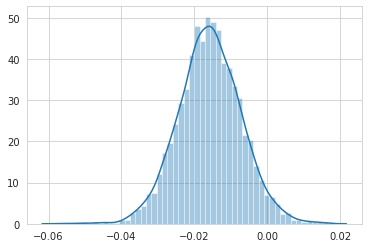

In [511]:
sns.distplot(trace.groupIdx)
sum(trace['groupIdx']>0) / len(trace['groupIdx'])

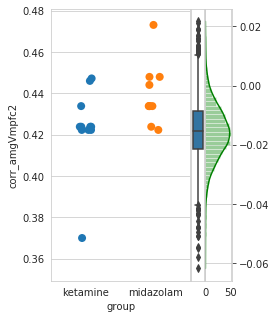

In [519]:
## Presenting differences between the groups using scatter plot for each group + 
## The resulting Bayesian analyses plots (density of differences and boxplot)

sns.set_style("whitegrid")
plt.figure(figsize=(5,5))
grid = plt.GridSpec(2, 20, wspace=.1, hspace=0.0) # building a grid to put the graphs in
plt.subplot(grid[:, :10])
#fig.add_subplot(grid[0,0])
g1= sns.stripplot(x='group',y='corr_amgVmpfc2',hue = 'group', data=dfBoth, s=8)
#g1 = sns.boxplot(x='group',y='meanAct',hue = 'group', data=df)
#g1.set_ylim(.35,.5)
g1.legend_.remove()

plt.subplot(grid[:, 10])
g3 = sns.boxplot(trace.groupIdx, orient='v')
#g3.set_ylim(.35,.5)
g3.set_yticks([])

plt.subplot(grid[:, 11:13])
g2 = sns.distplot(trace.groupIdx, vertical=True, color="Green")
#g2.set_ylim(.35,.5)
#g2.set_yticks([])
g2.yaxis.tick_right()

In [413]:
######## T test instead?
with pm.Model() as model:
    ketamine_mean = pm.Normal('ketamine_mean', mu = 0, sd=.1)
    midazolam_mean = pm.Normal('midazolam_mean', mu = 0, sd=.1) 
    
    ketamine_std = pm.Uniform('ketamine_std', lower=1, upper=30)
    midazolam_std = pm.Uniform('midazolam_std', lower=1, upper=30)
    
    ν = pm.Exponential('ν_min_one', 1/.05) + .01

with model:
    λ1 = ketamine_std**-2
    λ2 = midazolam_std**-2 

    group1 = pm.StudentT('group1', nu=ν, mu=ketamine_mean, lam=λ1, observed=dfBoth.corr_amgVmpfc2[dfBoth.group=='ketamine'])
    group2 = pm.StudentT('group2', nu=ν, mu=midazolam_mean, lam=λ2, observed=dfBoth.corr_amgVmpfc2[dfBoth.group=='midazolam'])

In [414]:
with model:

    diff_of_means = pm.Deterministic('difference of means',  ketamine_mean - midazolam_mean)
    diff_of_stds = pm.Deterministic('difference of stds',  ketamine_std - midazolam_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt(
                                   (ketamine_std**2 + midazolam_std**2) / 2))
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_min_one, midazolam_std, ketamine_std, midazolam_mean, ketamine_mean]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:02<00:00, 4000.37draws/s]


In [415]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ketamine_mean,0.081,0.095,-0.100,0.257,0.001,0.001,8707.0,6382.0,8702.0,6302.0,1.0
midazolam_mean,0.076,0.097,-0.114,0.249,0.001,0.001,7741.0,5984.0,7741.0,6553.0,1.0
ketamine_std,1.159,0.176,1.000,1.459,0.002,0.001,7754.0,7409.0,6124.0,3666.0,1.0
midazolam_std,1.183,0.207,1.000,1.528,0.002,0.002,7356.0,6942.0,5478.0,3544.0,1.0
ν_min_one,0.452,0.126,0.225,0.685,0.002,0.001,7035.0,6916.0,6845.0,5519.0,1.0
difference of means,0.004,0.135,-0.248,0.258,0.001,0.001,8115.0,5015.0,8128.0,6273.0,1.0
difference of stds,-0.024,0.273,-0.537,0.474,0.003,0.002,7699.0,6079.0,8201.0,6570.0,1.0
effect size,0.004,0.116,-0.210,0.226,0.001,0.001,8399.0,5086.0,8405.0,6633.0,1.0


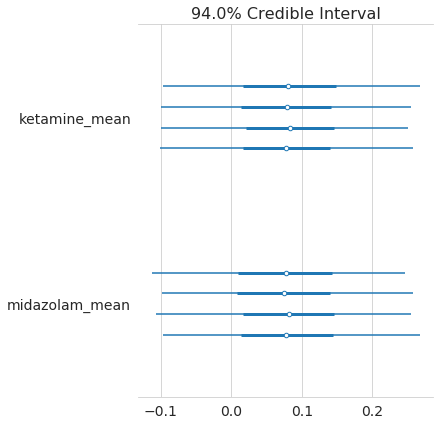

In [416]:
pm.forestplot(trace, var_names=['ketamine_mean',
                                'midazolam_mean']);

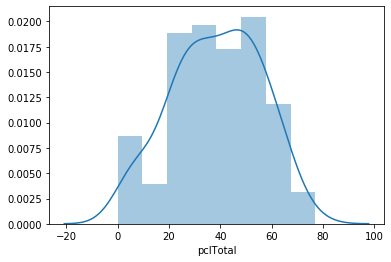

In [22]:
# check association with PCL score
## read pcl scores
pclDf = pd.read_csv('/home/or/Documents/kpe_analyses/KPEIHR0009_DATA_2019-10-07_1121.csv')
# take only KPE patients
pclDf = pclDf[pclDf['scr_id'].str.startswith('KPE')]
dfP = pd.DataFrame({'subject': pclDf['scr_id']})
dfP_PCL = pclDf[['scr_id','redcap_event_name','pcl5_1', 'pcl5_2', 'pcl5_3', 'pcl5_4', 'pcl5_5', 'pcl5_6', 'pcl5_7',
 'pcl5_8', 'pcl5_9', 'pcl5_10', 'pcl5_11', 'pcl5_12', 'pcl5_13', 'pcl5_14', 'pcl5_15', 'pcl5_16', 'pcl5_17',
 'pcl5_18', 'pcl5_19', 'pcl5_20']]
# remove NAs
dfP_PCL = dfP_PCL.dropna()
# set list of columns for analysis
colList = list(dfP_PCL)
colList.remove('scr_id')
colList.remove('redcap_event_name')
# set total pcl scores 
dfP_PCL['pclTotal'] = dfP_PCL[colList].sum(axis=1)
sns.distplot(dfP_PCL.pclTotal)

In [23]:
# reshape it to wide
df2=dfP_PCL.pivot(index = 'scr_id',columns='redcap_event_name', values='pclTotal')
list(df2)
df2 = df2.rename(columns={"30_day_follow_up_s_arm_1": "30Days", "90_day_follow_up_s_arm_1": "90Days",
                    "screening_selfrepo_arm_1": "Screening", "visit_1_arm_1": "Visit1", 
                 
                          "visit_7_week_follo_arm_1": "Visit7"})
#df2['scr_id'] = dfP_PCL['scr_id']
df2

redcap_event_name,30Days,90Days,Screening,Visit1,Visit7
scr_id,,,,,
KPE 1560,NaN,NaN,77.0,NaN,NaN
KPE 1565,NaN,NaN,60.0,NaN,NaN
KPE006,NaN,NaN,36.0,NaN,NaN
KPE008,56.0,49.0,NaN,58.0,61.0
KPE1205,NaN,NaN,43.0,NaN,NaN
...,...,...,...,...,...
KPE1548,NaN,NaN,43.0,NaN,NaN
KPE1549,NaN,NaN,12.0,NaN,NaN
KPE1556,NaN,NaN,0.0,NaN,NaN


In [24]:
# merging two data frames toghether
dfTest = pd.merge(dfBoth, df2, on = 'scr_id')
# create difference pcl score
dfTest['days30_1'] = dfTest['30Days'] - dfTest.Visit1
dfTest['days30_s'] = dfTest['30Days'] - dfTest.Screening
dfTest['days7_1'] = dfTest['Visit7'] - dfTest.Visit1
dfTest

NameError: name 'dfBoth' is not defined

In [19]:
sns.lmplot(x='days30_s',y='corr_amgHipp2',hue='group', data=dfTest)
naMask = np.isnan(dfTest['days30_s'])
scipy.stats.pearsonr(dfTest['days30_s'][~naMask], dfTest['hippAmgDelta'][~naMask])

NameError: name 'dfTest' is not defined

In [479]:
## Loading GSR data
dfGSR = pd.read_csv('/home/or/kpe_task_analysis/testing.csv')

# add KPE at the beginning of each scr id
dfGSR['scr_id'] = "KPE" + dfGSR["scr_id"].map(str) 
# pclDat[((pclDat['redcap_event_name'] == 'screening_selfrepo_arm_1'
dfGSR_trauma1 = dfGSR[(dfGSR["trial_type"]=='trauma1')]
dfGSR_trauma1

,Unnamed: 0,Event.Nr,CDA.nSCR,CDA.Latency,CDA.AmpSum,CDA.SCR,CDA.ISCR,CDA.PhasicMax,CDA.Tonic,TTP.nSCR,TTP.Latency,TTP.AmpSum,Global.Mean,Global.MaxDeflection,Event.NID,Event.Name,scr_id,scan,trial_type,med_cond
0,0,1,0.0,0.9016,0.4052,0.3246,0.3246,0.7402,1.4113,1,2.3360,1.3016,15.6569,0.7829,5,5,KPE1464,4,trauma1,1
9,9,1,-1.0,0.638,0.1162,0.2063,0.2063,0.7423,1.9943,1,2.2920,1.3637,13.6781,0.9967,5,5,KPE1464,3,trauma1,1
18,18,1,0.0,0.6579,-0.395,-0.4127,-0.4127,-0.2315,0.6057,1,2.7850,-0.3483,19.2113,0.0799,5,5,KPE1464,2,trauma1,1
27,27,1,2.0,-1.1047,2.2371,2.0743,2.0743,1.2806,1.0371,1,1.3380,2.2047,14.1352,2.5449,5,5,KPE1464,1,trauma1,1
36,36,1,-1.0,NaN,-0.5283,-0.5194,-0.5194,-0.5895,-0.1925,0,NaN,-0.3333,13.0094,0.0000,5,5,KPE1480,4,trauma1,0
45,45,1,2.0,-1.0119,-0.3137,-0.3186,-0.3186,-0.3356,2.1935,0,NaN,-0.4328,16.4314,0.0043,5,5,KPE1480,2,trauma1,0
54,54,1,0.0,1.7012,2.6479,2.6494,2.6494,2.6621,0.8510,0,NaN,NaN,7.6036,1.0567,5,5,KPE1480,1,trauma1,0
63,63,1,1.0,1.0568,-0.0847,0.6461,0.6461,0.5765,2.3275,1,1.8330,2.4229,2.8402,0.0152,5,5,KPE1387,3,trauma1,1
72,72,1,-1.0,NaN,-0.7928,-1.0284,-1.0284,-0.1981,2.2788,0,NaN,-0.3333,4.5891,0.0019,5,5,KPE1387,2,trauma1,1
81,81,1,0.0,0.4834,2.6038,2.6406,2.6406,2.6318,1.7634,0,NaN,-0.4849,4.3948,0.6925,5,5,KPE1387,1,trauma1,1


In [480]:
# make it wide
dfGSR_wide = dfGSR_trauma1.pivot(index='scr_id', columns='scan', values=['CDA.PhasicMax', 'med_cond'])
dfGSR_wide['3rd_1st'] = dfGSR_wide['CDA.PhasicMax', 3] - dfGSR_wide['CDA.PhasicMax', 1]
dfGSR_wide['begin_endPE'] = dfGSR_wide['CDA.PhasicMax', 2] - dfGSR_wide['CDA.PhasicMax', 1]
print(dfGSR_wide.columns)
gsronly = dfGSR_wide[['3rd_1st','begin_endPE' ,'med_cond']]

MultiIndex([('CDA.PhasicMax',  1),
            ('CDA.PhasicMax',  2),
            ('CDA.PhasicMax',  3),
            ('CDA.PhasicMax',  4),
            (     'med_cond',  1),
            (     'med_cond',  2),
            (     'med_cond',  3),
            (     'med_cond',  4),
            (      '3rd_1st', ''),
            (  'begin_endPE', '')],
           names=[None, 'scan'])


In [481]:
dfGSR_wide

CDA.PhasicMax                         med_cond                3rd_1st  \
scan                1       2       3       4        1    2    3    4           
scr_id                                                                          
KPE1223       -0.3880  1.5277 -0.6498 -0.5968      1.0  1.0  1.0  1.0 -0.2618   
KPE1293        2.3203  0.9665 -0.8664  2.6637      1.0  1.0  1.0  1.0 -3.1867   
KPE1315       -0.4385 -0.6947     NaN     NaN      1.0  1.0  NaN  NaN     NaN   
KPE1339        2.6288  1.8498 -0.6649  1.7232      1.0  1.0  1.0  1.0 -3.2937   
KPE1343        2.3135 -0.7353 -0.6093  0.0748      1.0  1.0  1.0  1.0 -2.9228   
KPE1356        1.1299  1.4030  1.3996 -0.4368      0.0  0.0  0.0  0.0  0.2697   
KPE1364        1.2448  0.0338  0.4436 -0.0878      0.0  0.0  0.0  0.0 -0.8012   
KPE1387        2.6318 -0.1981  0.5765     NaN      1.0  1.0  1.0  NaN -2.0553   
KPE1390        2.6366  1.6086 -0.5554     NaN      0.0  0.0  0.0  NaN -3.1920   
KPE1464        1.2806 -0.2315  0.7423  0.7402      1.0  1.0  1.0  1.0 -0.5383   
KPE1480        2.6621 -0.3356     NaN -0.5895      0.0  0.0  NaN  0.0     NaN   

        begin_endPE  
scan                 
scr_id               
KPE1223      1.9157  
KPE1293     -1.3538  
KPE1315     -0.2562  
KPE1339     -0.7790  
KPE1343     -3.0488  
KPE1356      0.2731  
KPE1364     -1.2110  
KPE1387     -2.8299  
KPE1390     -1.0280  
KPE1464     -1.5121  
KPE1480     -2.9977

In [482]:
gsrMerged = gsronly.merge(dfBoth, left_on='scr_id', right_on='scr_id', how='outer')
# drop NAs
#gsrMerged = gsrMerged.dropna(subset=[('3rd_1st', '')])
# change wierd column name
gsrMerged=gsrMerged.rename(columns = {('3rd_1st', ''):'three_one'})
gsrMerged=gsrMerged.rename(columns = {('med_cond' ,1): 'med_cond'})
gsrMerged=gsrMerged.rename(columns = {('begin_endPE', ''): 'begin_endPE'})
gsrMerged.columns

/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


Index([         'scr_id',       'three_one',     'begin_endPE',
              'med_cond',   ('med_cond', 2),   ('med_cond', 3),
         ('med_cond', 4),           'group',   'corr_amgHipp2',
        'corr_amgVmpfc2', 'corr_hippVmpfc2',   'corr_amgHipp1',
        'corr_amgVmpfc1', 'corr_hippVmpfc1',    'hippAmgDelta',
         'amgVmpfcDelta',  'hippVmpfcDelta'],
      dtype='object')

(0.2845731067763817, 0.45798341866666903)

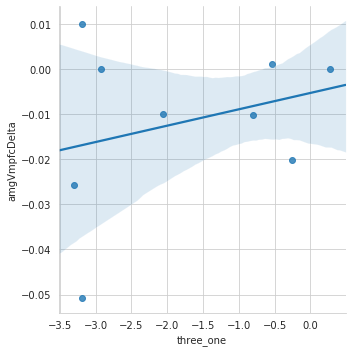

In [484]:
gsrMerged
sns.lmplot(x='three_one', y='amgVmpfcDelta', data=gsrMerged)
naMask = np.isnan(gsrMerged['three_one'])
scipy.stats.pearsonr(gsrMerged['three_one'][~naMask], gsrMerged['amgVmpfcDelta'][~naMask])

# Lets load the AAL atlas and look only on the right amygdala-hippocampus

In [5]:
first = np.load('/home/or/kpe_task_analysis/trauma_ses1.npy')
second = np.load('/home/or/kpe_task_analysis/trauma_ses2.npy')

deltaMatrix_each = np.array(second) - np.array(first)
deltaMat_zfisher = []
for mat2, mat1 in zip(second, first):
    mat1z = np.arctanh(mat1)
    mat2z = np.arctanh(mat2)
    deltaMat = mat2z - mat1z
    deltaMat_zfisher.append(deltaMat)

deltaMatz = np.array(deltaMat_zfisher)

#first = 
#second = np.load('/home/or/kpe_task_analysis/trauma_ses2.npy') # load second session 21 subjects using AAL atlas

In [6]:
left_amg_hippo = deltaMatz[36,40,:]

gsrMerged['left_amgHippo'] = left_amg_hippo

NameError: name 'gsrMerged' is not defined

In [7]:
sns.lmplot(x='left_amgHippo', y='three_one',hue='group', data=gsrMerged)
scipy.stats.pearsonr(gsrMerged['three_one'][~naMask], gsrMerged['left_amgHippo'][~naMask])

NameError: name 'gsrMerged' is not defined

In [8]:
dfTest['left_amgHippo'] = left_amg_hippo
sns.lmplot(x='left_amgHippo', y='days7_1',hue='group', data=dfTest)

maskNan = np.isnan(dfTest['days7_1'])

scipy.stats.pearsonr(dfTest.left_amgHippo[~maskNan], dfTest.days7_1[~maskNan])

NameError: name 'dfTest' is not defined

In [9]:
# lets scale it and run bayesian to make inference better
dfTest['left_hipAmg_Z'] = (dfTest.left_amgHippo - dfTest.left_amgHippo.mean()) / dfTest.left_amgHippo.std(ddof=0)
dfTest['Days7_1Z'] = (dfTest.days7_1 - dfTest.days7_1.mean()) / dfTest.days7_1.std(ddof=0)

NameError: name 'dfTest' is not defined

In [212]:
# run pymc3 GLM
# play with glm module of pymc3
import pymc3 as pm
from pymc3.glm import GLM

with pm.Model() as model_glm:
    GLM.from_formula('Days7_1Z ~ left_hipAmg_Z', data= dfTest, 
                   #  priors= {'Intercept': pm.Normal.dist(mu=0, sd=2),
                    #          'left_hipAmg_Z': pm.Normal.dist(mu=0, sd=2),
                     #        }
                    )
    trace = pm.sample(draws=5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, left_hipAmg_Z, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 40000/40000 [00:05<00:00, 6753.17draws/s]


In [213]:
pm.summary(trace, credible_interval=.9)

,mean,sd,hpd_5%,hpd_95%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.042,0.244,-0.354,0.439,0.002,0.002,17211.0,7825.0,17703.0,12051.0,1.0
left_hipAmg_Z,0.671,0.243,0.279,1.069,0.002,0.001,17035.0,15917.0,17614.0,12540.0,1.0
sd,0.897,0.206,0.589,1.191,0.002,0.001,11779.0,11316.0,12123.0,9485.0,1.0


In [188]:
trace['Intercept'][-200:].shape

(200,)

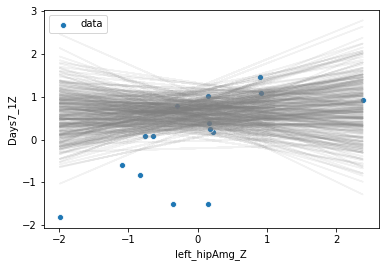

In [216]:
t=trace
x = dfTest['left_hipAmg_Z']
y = dfTest['Days7_1Z']
sns.scatterplot(x='left_hipAmg_Z', y='Days7_1Z', data=dfTest, label='data')
for a_, b_ in zip(t['Intercept'][-300:], t['left_hipAmg_Z'][-300:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
#plt.plot(x, a*x + _b, label='true regression line', lw=3., c='red')
plt.legend(loc='best')

In [503]:
def pearsonr_ci(x,y,alpha=0.05):
    from scipy import stats
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [505]:
pearsonr_ci(dfTest.left_amgHippo[~maskNan], dfTest.days7_1[~maskNan])

(0.6587333583234611,
 0.007571957688924434,
 0.22106909036290767,
 0.8755474295202351)